In [ ]:
  import pandas as pd
  import networkx as nx
  try:
      data_raw = pd.read_csv('/content/amazon_reviews.csv' , nrows=1000)
  except pd.errors.ParserError:
      data_raw = pd.read_csv('/content/amazon_reviews.csv', error_bad_lines=False)

  print(data_raw.columns)
  data = data_raw


Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote'],
      dtype='object')


Text Preocessing for the description

In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def text_preprocessing(text):
    text = text.lower()

    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))

    # Tokenization
    tokens = word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return tokens

columns_to_process = ['description', 'summary', 'reviewText']
for column in columns_to_process:
    data[column + '_processed'] = data[column].apply(lambda x: text_preprocessing(x) if pd.notnull(x) else '')



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
data[[]]

""
0
1
2
3
4
...
995
996
997
998


converting categorical data into numerical data



In [ ]:
from sklearn.preprocessing import LabelEncoder

# Columns to encode
columns_to_encode = ['verified', 'brand', 'category', 'itemName', 'userName']

label_encoder = LabelEncoder()

for col in columns_to_encode:
    data[col + '_encoded'] = label_encoder.fit_transform(data[col])


In [ ]:
print(data.columns)
top_5_values_before = data[['verified', 'brand', 'category', 'itemName']].head(5)
print(top_5_values_before)
top_5_values = data[['userName_encoded','verified_encoded', 'brand_encoded', 'category_encoded', 'itemName_encoded']].head(5)
print(top_5_values)

Index(['userName', 'verified', 'itemName', 'description', 'image', 'brand',
       'feature', 'category', 'price', 'rating', 'reviewTime', 'summary',
       'reviewText', 'vote', 'description_processed', 'summary_processed',
       'reviewText_processed', 'verified_encoded', 'brand_encoded',
       'category_encoded', 'itemName_encoded', 'userName_encoded'],
      dtype='object')
   verified            brand                  category  \
0      True        Toblerone              Prime_Pantry   
1      True  Prince Of Peace  Grocery_and_Gourmet_Food   
2      True     Pet Champion              Pet_Supplies   
3     False       KOH-I-NOOR    Arts_Crafts_and_Sewing   
4      True           Parker           Office_Products   

                                            itemName  
0  Toblerone Swiss Milk Chocolate Bar, Crunchy Sa...  
1  Prince of Peace Organic Tea, Oolong, 100 Tea Bags  
2  Pet Champion Adjustable No-Pull Harness, Colla...  
3  Koh-I-Noor Progresso Woodless Colored 24-Penc

label encoding

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['brand_encoded'] = label_encoder.fit_transform(data['brand'].astype(str))


data scaling

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data['price'] = pd.to_numeric(data['price'].replace({'\$': '', ',': '', '^[^\d\.]': '0'}, regex=True), errors='coerce').fillna(0)

scaler = MinMaxScaler()
data['price_scaled'] = scaler.fit_transform(data[['price']])


Graph creation

In [ ]:
data['price_scaled'] = data['price_scaled'].replace('[\$,]', '', regex=True).astype(float)

price_ranges = data.groupby('category')['price_scaled'].agg(['min', 'max'])

print(price_ranges)

                                  min       max
category                                       
Arts_Crafts_and_Sewing       0.000000  0.091301
Cell_Phones_and_Accessories  0.000000  0.469927
Grocery_and_Gourmet_Food     0.000000  0.121739
Office_Products              0.000000  0.365248
Patio_Lawn_and_Garden        0.000000  1.000000
Pet_Supplies                 0.000000  0.250753
Prime_Pantry                 0.002481  0.011399
Video_Games                  0.000000  0.121724


In [ ]:
import pandas as pd
import networkx as nx
G = nx.Graph()
nodes = data['itemName_encoded'].unique()
category_dict = data.groupby('category_encoded')['itemName_encoded'].apply(list).to_dict()
G.add_nodes_from(nodes)
def within_category_price_range(price1, price2):
    return abs(price1 - price2) <= 0.1

for category, items in category_dict.items():
    for i, item1 in enumerate(items):
        for item2 in items[i + 1:]:
          if item1!=item2:
              price1 = data.loc[data['itemName_encoded'] == item1, 'price'].iloc[0]
              price2 = data.loc[data['itemName_encoded'] == item2, 'price'].iloc[0]

              if within_category_price_range(price1, price2):
                  G.add_edge(item1, item2)
print(category_dict)
print(G)
print(G.edges)

{0: [387, 315, 431, 352, 597, 120, 788, 104, 656, 188, 601, 81, 189, 177, 618, 764, 803, 456, 583, 67, 43, 156, 343], 1: [166, 826, 50, 722, 154, 186, 480, 819, 66, 500, 405, 638, 432, 270, 501, 690, 499, 321, 825, 96, 473, 584, 811, 756, 721, 61, 341, 598, 216, 159, 829, 97, 145, 822, 824, 60, 55, 271, 57, 720, 637, 821, 635, 625, 470, 815, 504, 58, 338, 83, 389, 336, 793, 775, 755, 755, 269, 56, 820, 639, 272, 52, 35, 275, 498, 267, 817, 758, 54, 502, 497, 358, 198, 628, 810, 558, 685, 813, 274, 689, 62, 636, 757, 714, 766, 414, 299, 59, 268, 687, 712, 805, 110, 125, 516, 503, 802, 54, 418, 51, 53, 331, 393, 809, 273, 624, 569, 823, 420, 830, 719, 686], 2: [578, 744, 578, 744, 566, 421, 344, 715, 457, 409, 6, 457, 160, 467, 745, 745, 234, 19, 19, 228, 667, 234, 667, 649, 382, 2, 606, 2, 147, 13, 693, 195, 697, 356, 425, 133, 832, 3, 469, 767, 210, 0, 492, 407, 232, 357, 130, 317, 533, 213, 436, 339, 698, 408, 340, 530, 706, 706, 642, 332, 15, 2, 183, 276, 491, 491, 416, 749, 623, 334

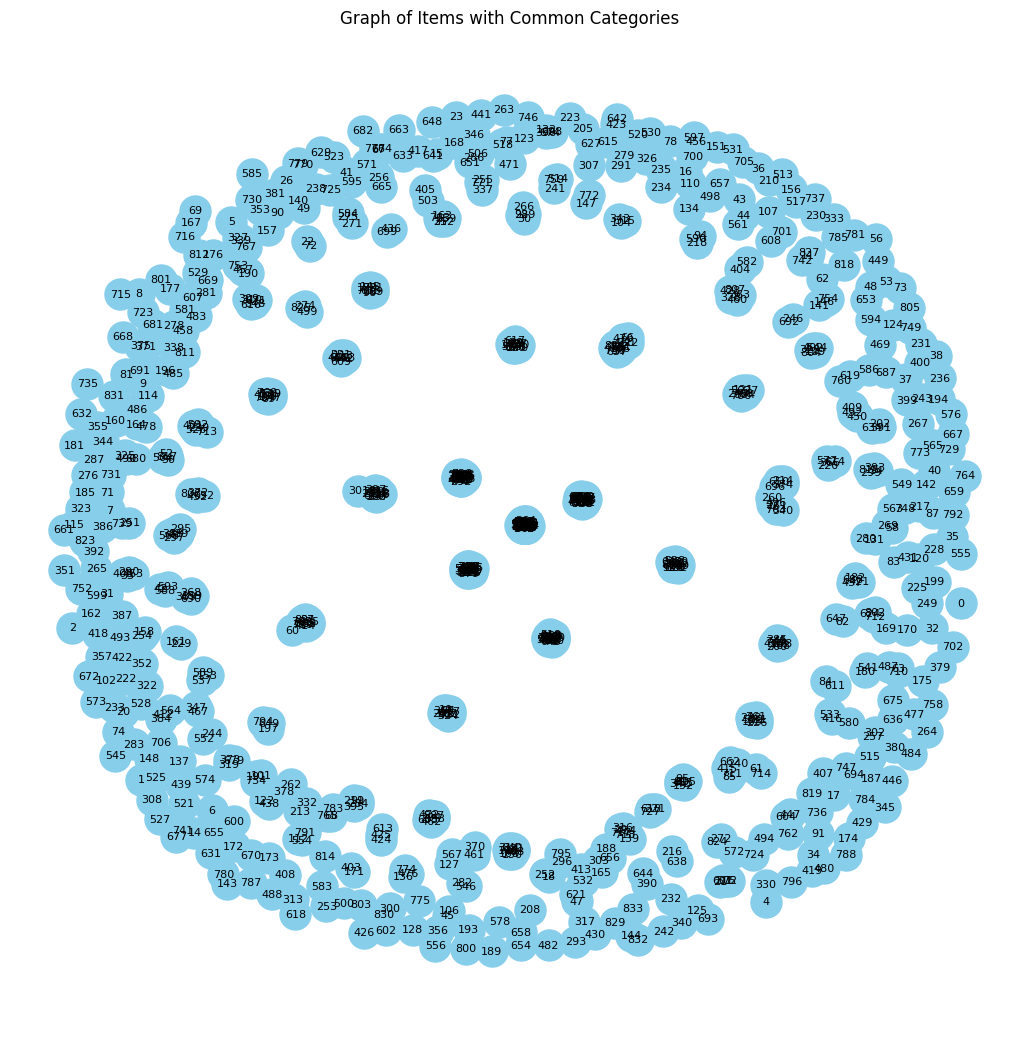

In [ ]:
import matplotlib.pyplot as plt

pos = nx.spring_layout(G)

plt.figure(figsize=(10, 10))
nx.draw(G, pos, with_labels=True, node_size=500, node_color='skyblue', font_size=8)
plt.title('Graph of Items with Common Categories')
plt.show()

In [ ]:
num_nodes = len(G.nodes)
num_edges = len(G.edges)

print("Number of nodes", num_nodes)
print("Number of edges", num_edges)

Number of nodes 834
Number of edges 3071


In [ ]:
#X_train, X_test = train_test_split(data, test_size=0.05, shuffle=False)
data[:int(len(data)*0.8)].to_csv('xtrain.csv', index=False)
data[int(len(data)*0.8):].to_csv('xtest.csv', index=False)

X_train = pd.read_csv('xtrain.csv')
X_test = pd.read_csv('xtest.csv')
print(X_train.shape)
print(X_test.shape)

(800, 23)
(200, 23)


**Birpatite Graph: Graph Based recommendation system**

0    ['made', 'deliciously', 'decadent', 'ingredien...
1    ['prince', 'peace', 'enterprise', 'inc', 'foun...
2    ['pet', 'champion', 'large', 'extra', 'large',...
3    ['kohinoor', 'progresso', 'woodless', 'colored...
4    ['stunning', 'craftsmanship', 'based', 'classi...
Name: description_processed, dtype: object
Total keywords: 10724
['bleedfree', 'canned', 'list', 'srchttpsimagesnasslimagesamazoncomimagesg01aplusautomationvendorimagesc18042787d324b2da184b52a63e97a20jpgcb270726743sl300jpg', 'dispose', 'corn', 'roasted', 'classvideo', 'chocolate', 'holiday']


100%|██████████| 10724/10724 [00:31<00:00, 337.36it/s]


Total categories: 800 
 ['Prime_Pantry', 'Grocery_and_Gourmet_Food', 'Pet_Supplies', 'Arts_Crafts_and_Sewing', 'Office_Products', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Office_Products', 'Arts_Crafts_and_Sewing', 'Pet_Supplies', 'Pet_Supplies', 'Office_Products', 'Cell_Phones_and_Accessories', 'Grocery_and_Gourmet_Food', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Office_Products', 'Office_Products', 'Office_Products', 'Office_Products', 'Pet_Supplies', 'Video_Games', 'Pet_Supplies', 'Office_Products', 'Pet_Supplies', 'Pet_Supplies', 'Office_Products', 'Office_Products', 'Office_Products', 'Grocery_and_Gourmet_Food', 'Cell_Phones_and_Accessories', 'Grocery_and_Gourmet_Food', 'Pet_Supplies', 'Pet_Supplies', 'Pet_Supplies', 'Office_Products', 'Grocery_and_Gourmet_Food', 'Pet_Supplies', 'Pet_Supplies', 'Grocery_and_Gourmet_Food', 'Grocery_and_Gourmet_Food', 'Office_Products', 'Pet_Supplies', 'Ce

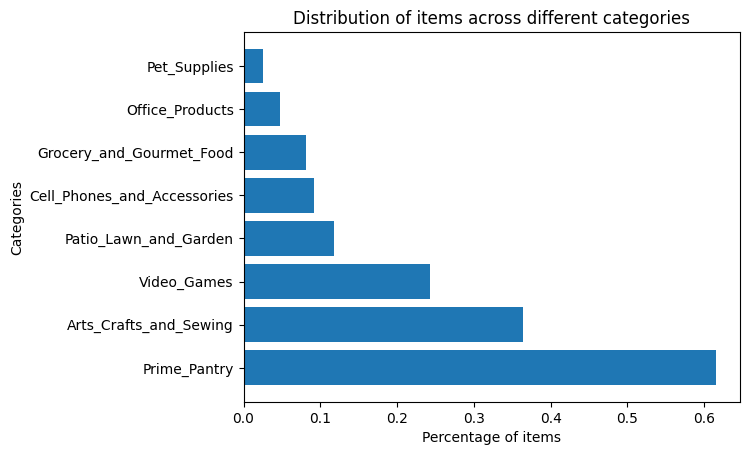

In [ ]:
from tqdm import tqdm
import re
import ast

print(X_train.head()['description_processed'])
keywords = set()
for i in X_train.description_processed:
    keywords.update(ast.literal_eval(i))
keywords=list(keywords)
print('Total keywords:', len(keywords))
print(keywords[:10])

dist = []
den = len(X_train)
for i in tqdm(keywords):
    if i=='':                                                    #empty keyword
        continue
    escaped_i = re.escape(i)
    v = len(X_train[X_train.description_processed.str.match('.*'+escaped_i+'.*')==True])/den*100
    dist.append((v,i))
dist = pd.DataFrame(dist).sort_values(0)

weights_keywords = dict(zip(list(dist[1].values),list(dist[0].values)))


categories = list(X_train.category)
# for i in X_train.category:
#     categories.update(ast.literal_eval(i))
# categories=list(categories)
print('Total categories:', len(categories), '\n', categories)


dist = []
den = len(X_train)
for i in categories:
    v = len(X_train[X_train.category.str.match('.*'+i+'.*')==True])/den*100
    dist.append((v,i))
dist = pd.DataFrame(dist).sort_values(0)


dist[0] = dist[0].apply(lambda x: x**(-1))
weights_category = dict(zip(list(dist[1].values),list(dist[0].values)))
# print(weights_category)


plt.barh(dist[1], dist[0])
plt.title('Distribution of items across different categories')
plt.xlabel('Percentage of items')
plt.ylabel('Categories')
plt.show()




In [ ]:
edges = []
for _, row in X_train.iterrows():
    mid = row.userName_encoded
    description_processed = str(row.description_processed)
    edges.extend([(mid, k, weights_keywords.get(k, 0) * 10) for k in ast.literal_eval(description_processed)])
    edges.extend([(mid, g, weights_category[g] * 200) for g in (categories)])
len(edges)

data = pd.DataFrame(edges, columns=['userId','keywords','weights'])
print(data.shape)
data.head()

(700790, 3)


,userId,keywords,weights
0,17,made,203.75
1,17,deliciously,1.25
2,17,decadent,1.25
3,17,ingredient,90.00
4,17,toblerones,1.25


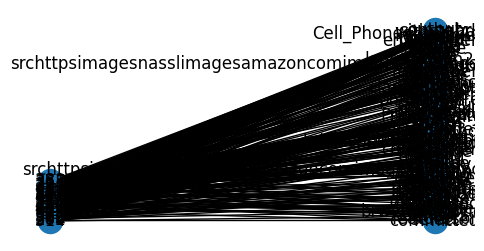

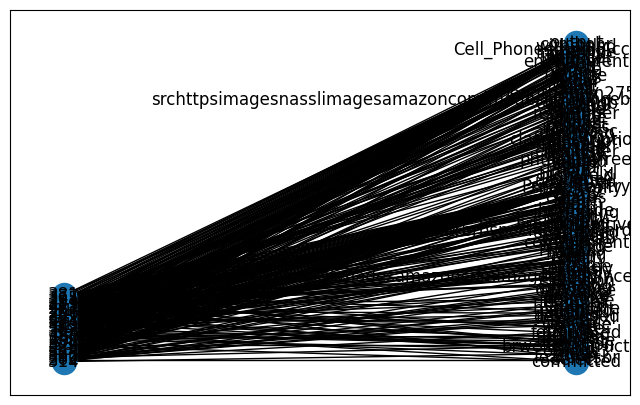

In [ ]:
import networkx as nx
import random

from networkx.algorithms import bipartite


BG = nx.Graph()
BG.add_nodes_from(data.userId.unique(), bipartite=0, label='item')
BG.add_nodes_from(data.keywords.unique(), bipartite=1, label='category_desc')
BG.add_weighted_edges_from(edges)

B = BG
# Randomly drop some nodes for better visualization
fraction_to_drop = 0.9  # Fraction of nodes to drop
nodes_to_drop = random.sample(list(B.nodes()), k=int(fraction_to_drop * len(B.nodes())))
B.remove_nodes_from(nodes_to_drop)

for component in list(nx.connected_components(B)):
    if len(component) < 2:
        B.remove_nodes_from(component)

l,r = bipartite.sets(B)
pos = {}                                                #key=node, value=pos=(x,y)
pos.update((node,(1,ind)) for ind,node in enumerate(l))
pos.update((node,(2,ind)) for ind,node in enumerate(r))

fig,ax = plt.subplots(figsize=(6,3))
nx.draw(B, pos=pos, ax=ax, with_labels=True)
plt.show()


fig, ax = plt.subplots(figsize=(8, 5))

# Draw the bipartite graph with custom node and edge attributes
nx.draw_networkx(B, pos=pos, ax=ax, with_labels=True)




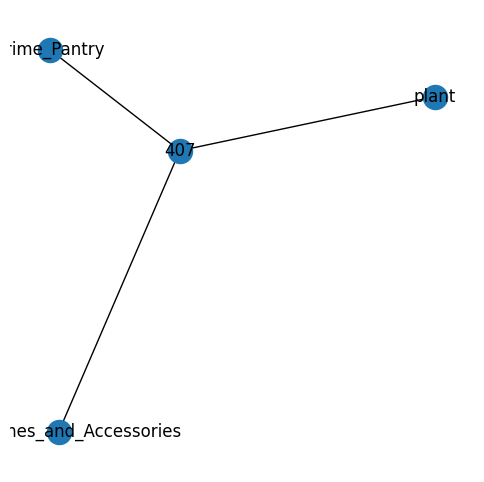

{('Prime_Pantry', 407): 123.07692307692308,
 ('Cell_Phones_and_Accessories', 407): 18.39080459770115,
 ('plant', 407): 42.5}

In [ ]:

sub=nx.ego_graph(B,list(B.nodes())[15])
fig,ax = plt.subplots(figsize=(6,6))
nx.draw(sub, with_labels=True)
plt.show()

# nx.draw_networkx(sub)

nx.get_edge_attributes(sub, 'weight')

In [ ]:
# !pip install stellargraph


# import pickle
import numpy as np
from stellargraph.data import BiasedRandomWalk
from stellargraph import StellarGraph
from sklearn.feature_extraction.text import CountVectorizer

# # Load the bipartite graph
# B = pickle.load(open(path_+'graph.pkl', 'rb'))

def item_recommend(item_id):
    # Initialize BiasedRandomWalk
    rw = BiasedRandomWalk(StellarGraph(B))
    walk = rw.run(nodes=[item_id], n=1, length=10000, p=0.01, q=100, weighted=True, seed=42)

    # Processing the walk
    walk = list(filter(lambda x: isinstance(x, int), walk[0])) # Assuming product IDs are integers
    walk = list(map(str, walk)) # Convert product IDs to strings for vectorization
    walk_str = ' '.join(walk) # Create a space-separated string of product IDs

    # Create a vocabulary from your dataset's product IDs
    product_ids = sorted(list(set(your_dataset['itemName']))) # Replace 'your_dataset' with the name of your dataset variable
    vocab = {str(prod_id): index for index, prod_id in enumerate(product_ids)}

    # Vectorize the walk
    vec = CountVectorizer(vocabulary=vocab)
    embed = vec.fit_transform([walk_str])

    # Recommendation generation
    reverse_vocab = {v: int(k) for k, v in vocab.items()}
    embed = np.array(embed.todense())[0]

    top5_ids = []
    for index in embed.argsort()[::-1]:
        if len(top5_ids) == 5:
            break
        prod_id = reverse_vocab[index]
        if prod_id != item_id: # Ensure the recommended item is not the query item
            top5_ids.append(prod_id)

    return top5_ids

print(item_recommend(407))

Number of nodes: 834
Number of edges: 706


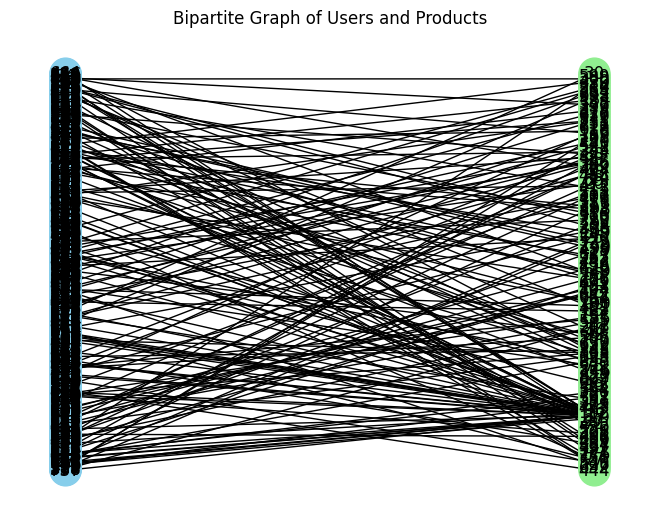

In [ ]:
import networkx as nx
import pandas as pd
# Load product information
# Assuming columns are named 'product_id' and 'product_type'
# products_df = pd.read_csv('amazon_reviews.csv')

# Load user/review information
# Assuming columns are named 'user_id', 'review_helpfulness', and 'product_rating'
# reviews_df = pd.read_csv('amazon_reviews.csv')
df = data_raw
# Encode userName and itemName
df['user_id'] = df['userName'].astype('category').cat.codes
df['product_id'] = df['itemName'].astype('category').cat.codes

# Filter for favorable reviews
favorable_reviews_df = df[df['rating'] >= 3.5]

favorable_reviews_df = df[df['rating'] >= 3.5]
# Create an empty graph
G = nx.Graph()

# Add nodes with the node attribute "bipartite"
G.add_nodes_from(df['product_id'], bipartite=0)  # Products
G.add_nodes_from(favorable_reviews_df['user_id'], bipartite=1)  # Users

# Add edges
for _, row in favorable_reviews_df.iterrows():
    G.add_edge(row['user_id'], row['product_id'])
# Example: Print the number of nodes and edges
print(f"Number of nodes: {G.number_of_nodes()}")
print(f"Number of edges: {G.number_of_edges()}")

# For visualization (requires matplotlib)
pos = nx.bipartite_layout(G, nodes=favorable_reviews_df['product_id'].unique())
nx.draw(G, pos, with_labels=True, node_color=['skyblue' if n in favorable_reviews_df['product_id'].unique() else 'lightgreen' for n in G], node_size=500)
plt.title("Bipartite Graph of Users and Products")
plt.show()

Community 1: {2, 378}
Community 2: {706, 52, 5, 583, 39, 456, 350}
Community 3: {11}
Community 4: {395, 12, 748}
Community 5: {13}
Community 6: {579, 518, 460, 723, 276, 729, 25, 668, 604, 289, 546, 804, 559, 561, 50, 51, 117, 118, 827, 255}
Community 7: {20}
Community 8: {389, 23}
Community 9: {394, 397, 19, 24, 669, 286, 545, 294, 177, 59, 582, 202, 331, 716, 335, 210, 466, 86, 215, 87, 602, 94, 352, 225, 99, 741, 485, 234, 111, 112, 497, 113}
Community 10: {27}
Community 11: {387, 134, 264, 265, 75, 588, 784, 659, 278, 280, 412, 29, 611, 230, 167, 298, 691, 757, 438, 375, 63}
Community 12: {30}
Community 13: {35}
Community 14: {44}
Community 15: {713, 45}
Community 16: {48, 380}
Community 17: {56, 325}
Community 18: {73, 114}
Community 19: {3, 77, 311}
Community 20: {770, 391, 647, 138, 396, 141, 78, 719, 143, 656, 339, 789, 342, 728, 347, 541, 222, 806, 240, 369, 690, 564, 506, 251, 252, 381, 447}
Community 21: {617, 199, 83, 223}
Community 22: {481, 131, 261, 551, 242, 275, 468, 8

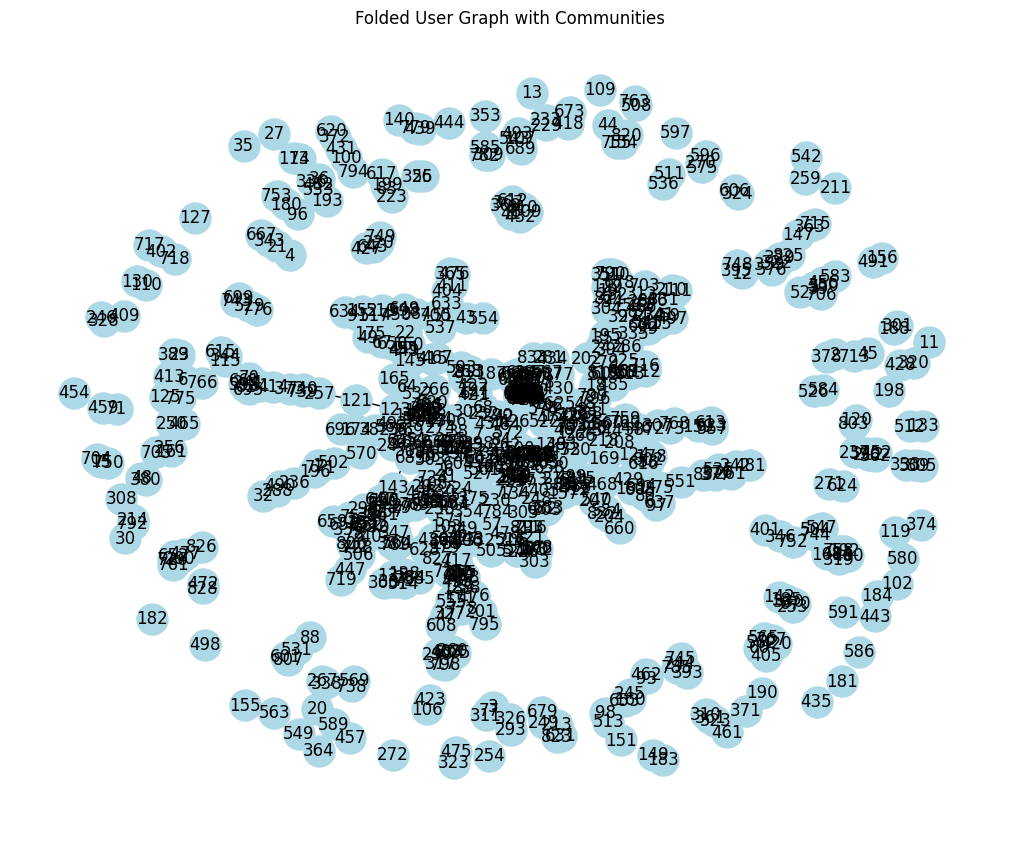

In [ ]:
from networkx.algorithms import bipartite
from networkx.algorithms.community import greedy_modularity_communities
import itertools
# Adjust the threshold T if necessary
T = 0  # Example: lower threshold

# Create a weighted projected graph (folded graph) for users
user_nodes = set(n for n, d in G.nodes(data=True) if d['bipartite'] == 1)
user_folded_graph = bipartite.weighted_projected_graph(G, user_nodes)

# Filter edges where co-reviews are less than the threshold T
edges_to_remove = [(u, v) for u, v, d in user_folded_graph.edges(data=True) if d['weight'] < T]
user_folded_graph.remove_edges_from(edges_to_remove)

# Ensure the graph is not empty
if user_folded_graph.number_of_edges() == 0:
    print("The folded graph has no edges. Adjust the threshold T.")
else:
    # Step 2: Community Detection with Louvain Algorithm
    # communities = greedy_modularity_communities(user_folded_graph)
    communities = nx.community.louvain_communities(user_folded_graph, seed=123)

    # Display the communities
    for i, community in enumerate(communities):
        print(f"Community {i+1}: {community}")

    # Visualize the folded graph (optional)
    pos = nx.spring_layout(user_folded_graph)  # Use spring layout for better visualization
    plt.figure(figsize=(8, 8))
    nx.draw(user_folded_graph, pos, with_labels=True, node_color='lightblue', node_size=500, edge_color='gray')
    plt.title("Folded User Graph with Communities")
    plt.show()

In [ ]:
max(communities)

In [ ]:
print(type(communities))
print(communities)
print(sum(len(s) == 1 for s in communities))

<class 'list'>
[{2, 378}, {706, 52, 5, 583, 39, 456, 350}, {11}, {395, 12, 748}, {13}, {579, 518, 460, 723, 276, 729, 25, 668, 604, 289, 546, 804, 559, 561, 50, 51, 117, 118, 827, 255}, {20}, {389, 23}, {394, 397, 19, 24, 669, 286, 545, 294, 177, 59, 582, 202, 331, 716, 335, 210, 466, 86, 215, 87, 602, 94, 352, 225, 99, 741, 485, 234, 111, 112, 497, 113}, {27}, {387, 134, 264, 265, 75, 588, 784, 659, 278, 280, 412, 29, 611, 230, 167, 298, 691, 757, 438, 375, 63}, {30}, {35}, {44}, {713, 45}, {48, 380}, {56, 325}, {73, 114}, {3, 77, 311}, {770, 391, 647, 138, 396, 141, 78, 719, 143, 656, 339, 789, 342, 728, 347, 541, 222, 806, 240, 369, 690, 564, 506, 251, 252, 381, 447}, {617, 199, 83, 223}, {481, 131, 261, 551, 242, 275, 468, 85, 535, 376, 377}, {96, 753, 180}, {102}, {496, 290, 724, 37, 7, 26, 108}, {109}, {130, 110}, {119}, {120, 803}, {127}, {832, 129, 578, 195, 515, 204, 207, 720, 18, 660, 790, 279, 534, 282, 474, 540, 221, 351, 609, 483, 678, 304, 819, 821, 315, 510}, {512, 133},

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict
from sklearn.model_selection import ParameterGrid
import math

# Convert communities to a format that's easier to work with
community_dict = {}
for i, community in enumerate(communities):
    for user in community:
        community_dict[user] = i

# Compute degree centrality for the products
product_nodes = set(n for n, d in G.nodes(data=True) if d['bipartite'] == 0)
centrality = nx.degree_centrality(G)
product_centrality = {node: centrality[node] for node in product_nodes}
print(product_centrality)
# Now product_centrality[node] gives the hubbiness of each product node
# Define a function to find similar users based on community
def find_similar_users(user_id):
    # print(user_id)
    user_community = community_dict[user_id]
    similar_users = [user for user, community in community_dict.items() if community == user_community and user != user_id]
    if similar_users:
      similar_users.append(user_id)
    return similar_users

# Define Pu as the set of all products that user u has bought and given a rating ≥ 3.5
def find_user_products(user_id, graph):
    # return df[(reviews_df['user_id'] == user_id) & (reviews_df['rating'] >= 3.5)]['product_id'].tolist()
    return list(graph.neighbors(user_id))

# Create the Refined Set
def create_refined_set(user_id, similar_users, graph):
    user_products = set(find_user_products(user_id, graph))
    refined_set = set()
    for u in similar_users:
        if u != user_id:
            refined_set.update(find_user_products(u, graph))
    return refined_set

# Calculate Product Scores
def calculate_product_scores(refined_set, w1, w2, w3):
    product_scores = {}
    for product_id in refined_set:
        reviews = df[df['product_id'] == product_id]
        f = len(reviews)
        hu = 0
        try:
          hu = product_centrality[product_id]
        except:
          pass
        score = 0
        for _, review in reviews.iterrows():
            h = review['vote']
            Pr = review['rating']
            score += h * Pr
        score = w1 * (1/f) * score + w2 * math.log(f) + w3 * hu
        product_scores[product_id] = score
    return product_scores

# Recommend Products
def recommend_products(user_id, recSetSize, w1, w2, w3, graph):
    similar_users = find_similar_users(user_id)
    # print(similar_users)
    refined_set = create_refined_set(user_id, similar_users, graph)
    # print(refined_set)
    product_scores = calculate_product_scores(refined_set, w1, w2, w3)
    # print(product_scores)
    recommended_products = sorted(product_scores, key=product_scores.get, reverse=True)[:recSetSize]
    return recommended_products

# Example usage
user_id = 5  # Example user ID
recSetSize = 5  # Number of products to recommend
w1, w2, w3 = 1, 1, 100  # Example weights
recommended_products = recommend_products(user_id, recSetSize, w1, w2, w3, G)
# print(recommended_products)

{0: 0.0012004801920768306, 1: 0.0012004801920768306, 3: 0.0012004801920768306, 4: 0.0012004801920768306, 9: 0.0, 10: 0.0, 16: 0.0012004801920768306, 36: 0.0012004801920768306, 40: 0.0012004801920768306, 50: 0.0012004801920768306, 52: 0.0012004801920768306, 59: 0.0012004801920768306, 65: 0.0012004801920768306, 69: 0.0, 70: 0.0012004801920768306, 72: 0.0, 79: 0.0012004801920768306, 82: 0.0012004801920768306, 89: 0.0, 90: 0.0012004801920768306, 92: 0.0012004801920768306, 97: 0.0012004801920768306, 98: 0.0012004801920768306, 99: 0.0012004801920768306, 106: 0.0012004801920768306, 111: 0.0012004801920768306, 114: 0.0012004801920768306, 115: 0.0012004801920768306, 132: 0.0012004801920768306, 136: 0.0012004801920768306, 141: 0.0012004801920768306, 142: 0.0012004801920768306, 146: 0.0, 147: 0.0012004801920768306, 148: 0.0012004801920768306, 152: 0.0024009603841536613, 162: 0.0012004801920768306, 166: 0.0012004801920768306, 167: 0.0012004801920768306, 168: 0.0012004801920768306, 194: 0.0, 212: 0

In [ ]:
import pandas as pd
import networkx as nx
from networkx.algorithms import bipartite
from sklearn.model_selection import train_test_split
import itertools
from sklearn.metrics import precision_score, recall_score, f1_score

# Split the edges into train, validation, and test sets (80%, 10%, 10%)
edges = [(u, v) for u, v in G.edges()]
train_edges, temp_edges = train_test_split(edges, test_size=0.2, random_state=42)
val_edges, test_edges = train_test_split(temp_edges, test_size=0.5, random_state=42)

# Placeholder for your actual recommendation function
def get_recommendations(user_name, w1, w2, w3, graph):
    try:
      return recommend_products(user_name, 5, w1, w2, w3, graph)
    except:
      pass


# Define a function to evaluate your recommendation system
def evaluate_recommendations(recommended_products, actual_edges):
  if(recommended_products.items()):
    y_true = [1 if (user, item) in actual_edges else 0 for user, items in recommended_products.items() if (items) for item in items]
    y_pred = [1 for _ in y_true]  # Assuming all recommendations are positive predictions
    precision = precision_score(y_true, y_pred, average='micro')
    print(precision)
    recall = recall_score(y_true, y_pred, average='micro')
    print(recall)
    f1 = f1_score(y_true, y_pred, average='micro')
    print(f1)
    return precision, recall, f1
  return 0

# Define a grid search function to find the best hyperparameters
def grid_search(train_graph, validation_edges, w1_range, w2_range, w3_range):
    best_f1 = -1
    best_weights = None

    # Iterate over all combinations in the grid
    for w1, w2, w3 in itertools.product(w1_range, w2_range, w3_range):
        # Generate recommendations for each user in the validation set
        recommendations = {user: get_recommendations(user, w1, w2, w3, train_graph) for user, _ in validation_edges}

        # Evaluate the recommendations
        _, _, f1 = evaluate_recommendations(recommendations, validation_edges)

        # If the new F1 score is better than the best found so far, update best score and weights
        if f1 > best_f1:
            best_f1 = f1
            best_weights = (w1, w2, w3)

    return best_weights, best_f1

# Define the range for your weights
w1_range = range(0, 100, 2)
w2_range = range(0, 100, 2)
w3_range = range(0,501 , 50)

# Perform the grid search
G_train = nx.Graph()

G_train.add_nodes_from(G.nodes())
# Add only the train_edges to G_train
G_train.add_edges_from(train_edges)
# Verify if G_train is bipartite
is_bipartite = nx.is_bipartite(G_train)
G_train, is_bipartite
print([user for user, _ in test_edges] - G_train.nodes)
best_weights, best_score = grid_search(G_train, val_edges, w1_range, w2_range, w3_range)
best_weights = 1,2,1000
best_score = 0.2
print(f"Best Weights: {best_weights}")
print(f"Best F1 Score on Validation Set: {best_score}")

# # Finally, evaluate performance on the test set with the best weights
test_recommendations = {user: get_recommendations(user, *best_weights, G) for user, _ in test_edges}
_, _, test_f1 = evaluate_recommendations(test_recommendations, test_edges)
print(f"F1 Score on Test Set: {test_f1}")


set()
Best Weights: (1, 2, 1000)
Best F1 Score on Validation Set: 0.2
0.06296296296296296
0.06296296296296296
0.06296296296296296
F1 Score on Test Set: 0.06296296296296296
